# Time Series Forecasting

In [0]:
## update the latest seaborn (0.9.0)
!pip install seaborn==0.9.0


In [1]:
## install a tool, prophet
!pip install prophet

fbprophet 0.4.post2 requires setuptools-git>=1.2, which is not installed.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
## setup our environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime  
from fbprophet import Prophet ## <----- new import
%matplotlib inline

## pandas print columns/rows option (100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## set the styling for seaborn (white)
sns.set_style("dark")

In [3]:
# lets use the sales dataset again
sales = pd.read_csv("/Users/Kyle_Staples/Documents/GitHub/IS834/datasets/sales.csv", parse_dates=['Order Date', 'Ship Date'])
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9426 entries, 0 to 9425
Data columns (total 25 columns):
Unnamed: 0              9426 non-null int64
Row ID                  9426 non-null int64
Order Priority          9426 non-null object
Discount                9426 non-null float64
Unit Price              9426 non-null float64
Shipping Cost           9426 non-null float64
Customer ID             9426 non-null int64
Customer Name           9426 non-null object
Ship Mode               9426 non-null object
Customer Segment        9426 non-null object
Product Category        9426 non-null object
Product Sub-Category    9426 non-null object
Product Container       9426 non-null object
Product Name            9426 non-null object
Product Base Margin     9354 non-null float64
Region                  9426 non-null object
State or Province       9426 non-null object
City                    9426 non-null object
Postal Code             9426 non-null int64
Order Date              9426 non-null 

In [4]:
# lets summarize sales by order date again
sales_ts = sales.groupby("Order Date", as_index=False).sum()
sales_ts = sales_ts.loc[:, ["Order Date", "Sales"]]
sales_ts.head()

,Order Date,Sales
0,2010-01-01,193.88
1,2010-01-02,11808.32
2,2010-01-03,7934.24
3,2010-01-04,401.06
4,2010-01-05,6258.37


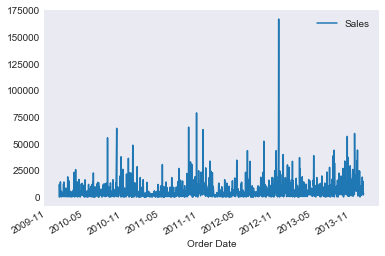

In [7]:
# quick plot
sales_ts.plot(x="Order Date", y="Sales", kind="line")

> Because we are interested in forecasting values, we want to use historical data to predict future values.  As with any type of prediction problem, we need to setup some method to assess accuracy

# Evaluation and Moving Average (MA) forecasting

There are a number of ways to evaluate timeseries forecasts, but to keep things within context of this course, let's use a simple** RMSE, or Root Mean Squared Error**

This simply is the different between the forecasts and the actual value (a residual), squared, and then take the square root.  We do this for every forecast in our dataset to arrive at 1 number.  The lower the **RMSE**, the better, just like in regression.

An intuitive, and often great first step, is to forecast via moving averages.  Simply, the moving average over some period (e.g. MA(4) is a 4-period moving average) is used to forecast the value.  It is a smoothing type of forecast, as the data are pooled together via an average in attempts to remove larger fluctations.  The accuracy of a MA forecast tends to be in the window selected.

In [0]:
# first, lets add a few moving averages
sales_ts['ma1'] = sales_ts['Sales'].shift().rolling(1).mean()
sales_ts['ma2'] = sales_ts['Sales'].shift().rolling(2).mean()
sales_ts['ma5'] = sales_ts['Sales'].shift().rolling(5).mean()
sales_ts['ma12'] = sales_ts['Sales'].shift().rolling(12).mean()

In [0]:
sales_ts.head(13)

In [0]:
# Now we calculate the RMSE for each prediction.  First we square the error/residual
# That is Sales is what we want to predict, and the MA(n) is the forecast for that value
sales_ts['ma1_se'] = (sales_ts['Sales'] - sales_ts['ma1'])**2
sales_ts['ma2_se'] = (sales_ts['Sales'] - sales_ts['ma2'])**2
sales_ts['ma5_se'] = (sales_ts['Sales'] - sales_ts['ma5'])**2
sales_ts['ma12_se'] = (sales_ts['Sales'] - sales_ts['ma12'])**2

In [0]:
# lets look at the data
sales_ts.head(13)

In [0]:
# lets only keep rows where every value is retained, this only chops off a few records and doesnt really matter in practice
sales_forecast = sales_ts.dropna()
print(len(sales_ts))
print(len(sales_forecast))

In [0]:
# keep just what we need
evals = sales_forecast.iloc[:, 6:]
evals.head()

In [0]:
## calculate the averages
evals_mean = evals.mean()
evals_mean

In [0]:
## take our Series and make it a dataframe, 
evals_df = pd.DataFrame({'mse': evals_mean})
evals_df

In [0]:
# now square root of the number
evals_df['rmse'] = np.sqrt(evals_df['mse'])
evals_df

In [0]:
# create a barplot showing a picture
evals_df['method'] = evals_df.index
evals_df.rmse.plot(kind="bar")

In [0]:
# visualize the forecasts - last 50
proof = sales_forecast.iloc[:, :6]
proof50 = proof.tail(50)
proof_eval = proof50.melt(id_vars="Order Date", var_name="method")
# fig, ax = plt.subplots(figsize=(10,4))  ## <---- this lets us access the figure and axes objects for finer control, using it to set the axis method
# fig = sns.lineplot(x="Order Date", y="value", data=proof_eval, hue="method")
# plt.show(fig)

# Prophet

![](https://cdn-images-1.medium.com/max/1600/0*tVCene42rgUTNv9Q.png)

Facebook built prophet to do robust, scalable, yet simple timeseries forecasting.  For our purposes, this can help us go a long way.

To learn more about prophet:

https://facebook.github.io/prophet/

In [0]:
# load the shampoo dataset from QTools with some basic cleanup
shampoo = pd.read_csv("shampoo.csv")
shampoo.dropna(inplace=True)
shampoo.columns = ['Month', 'Sales']
shampoo.head()

In [0]:
# lets create a date and remove month
shampoo['date'] = pd.date_range(start="2019-01-01", periods=36)
del shampoo['Month']
# reorder the columns
shampoo = shampoo.loc[:, ["date", "Sales"]]
shampoo.head()

In [0]:
shampoo.info()

In [0]:
# Prophet requires a dataframe with two coluns, ds and y, for the dates and values respectively
shampoo.columns = ["ds", "y"]
shampoo.head()

In [0]:
# create a model using prophet
model = Prophet()

In [0]:
# fit a model to our data - it might takea a few seconds
model.fit(shampoo)

> Above is just telling us that some of the settings were disabled, but if we want to include settings that account for daily and yearly seasonility, we can.

Prophet fit a model to our data, and has a nice helper function to extend our shampoo sales data into the future (add new dates) and use the model to forecast those values

In [0]:
# add 3 days to the shampoo dataset and get it ready to apply the forecasts
future = model.make_future_dataframe(periods=3, freq='D', include_history=True)

In [0]:
# add the forecasts to the dataset
shampoo_forecasts = model.predict(future)

In [0]:
# look at the tail of the dataset
shampoo_forecasts.tail()

In [0]:
# thats a lot of data on how prophet worked through the dataset to decompose various components of the dataset for forecasting
# we can plot the forecast
fig1 = model.plot(shampoo_forecasts)


Above shows us a plot of the forecast, along with the confidence of the estimate, which allows us to view the "risk" of our predictions

In [0]:
## we can also join this back to our original dataset
## outer join to include all data, because we added dates with prophet
shampoo_final = pd.merge(shampoo, shampoo_forecasts, how="outer", left_on=["ds"], right_on=["ds"])

In [0]:
# inspect the data - notice the last 3 do not have the original value, y, as expected
shampoo_final.tail()